# Uncertainty 

This is a tutorial for the uncertainty module.

In [1]:
import numpy as np
import os
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from pathos.pools import ProcessPool as Pool
import numpy as np

from climada import util
util.config.setup_logging("ERROR")

from climada.engine.uncertainty import UncVar, Uncertainty, UncImpact, UncCostBenefit
from climada.entity import BlackMarble, ImpactFunc, ImpactFuncSet
from climada.hazard import TropCyclone
from climada.util.value_representation import value_to_monetary_unit as vtm
from climada.util.plot import multibar_plot

from climada import CONFIG
ENT_TEST_MAT = CONFIG.exposures.test_data.dir().joinpath('demo_today.mat')
HAZ_TEST_MAT = CONFIG.hazard.test_data.dir().joinpath('atl_prob_no_name.mat')
from climada.entity import Entity
from climada.hazard import Hazard

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [17]:
def imp_fun_tc(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):    
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'TC'
    imp_fun.id = _id
    imp_fun.intensity_unit = 'm/s'
    imp_fun.intensity = np.linspace(0, 150, num=100)
    imp_fun.mdd = np.repeat(1, len(imp_fun.intensity))
    imp_fun.paa = np.array([sigmoid_func(v, G, v_half, vmin, k) for v in imp_fun.intensity])
    imp_fun.check()
    impf_set = ImpactFuncSet()
    impf_set.append(imp_fun)
    return impf_set

def xhi(v, v_half, vmin):
    return max([(v - vmin), 0]) / (v_half - vmin)
  
def sigmoid_func(v, G, v_half, vmin, k):
    return G * xhi(v, v_half, vmin)**k / (1 + xhi(v, v_half, vmin)**k)

CURR_DIR = "/Users/ckropf/Documents/Climada/Uncertainty"

def load_exp():
    file_name = os.path.join(CURR_DIR, "exp_AIA.h5")
    exp = BlackMarble()
    exp.read_hdf5(file_name)
    return exp
    
def load_haz():
    file_name = os.path.join(CURR_DIR, "tc_AIA.h5")
    haz= TropCyclone()
    haz.read_hdf5(file_name)
    return haz

## Impact 

In [18]:
exp = load_exp()
haz = load_haz()
impf_unc_fct = imp_fun_tc

distr_dict = {"G": sp.stats.uniform(0.8,1),
              "v_half": sp.stats.norm(75, 25),
              "vmin": sp.stats.uniform(15,30),
              "k": sp.stats.uniform(1, 5)
              }

unc_impf = UncVar(impf_unc_fct, distr_dict)

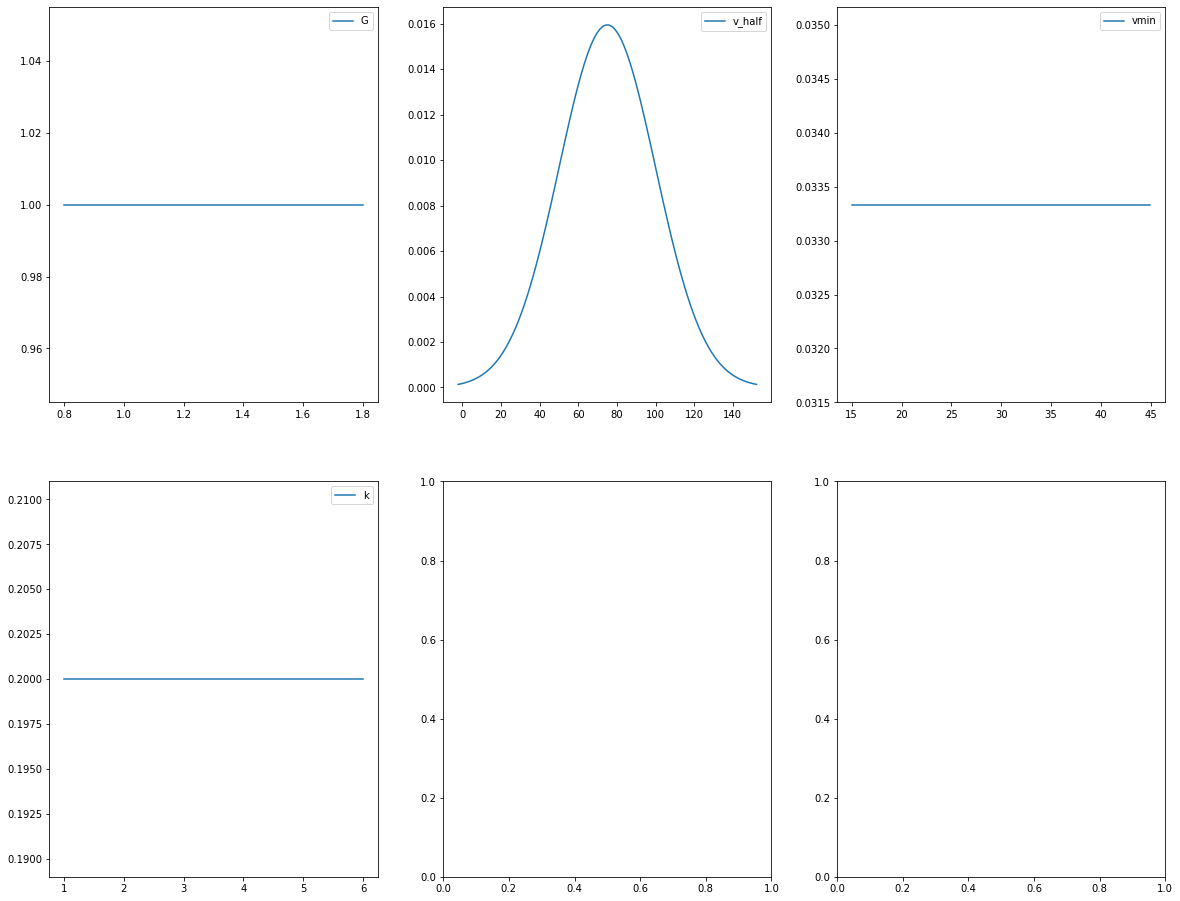

In [19]:
unc_impf.plot_distr();

In [23]:
unc = UncImpact(exp, unc_impf, haz)
unc.make_sample(N=10, calc_second_order=True)
unc.params

,G,v_half,vmin,k
0,1.019727,42.482370,30.556641,4.383789
1,1.080273,42.482370,30.556641,4.383789
2,1.019727,108.096701,30.556641,4.383789
3,1.019727,42.482370,16.376953,4.383789
4,1.019727,42.482370,30.556641,5.497070
...,...,...,...,...
95,1.363477,91.939151,28.564453,2.528320
96,0.924023,87.426717,28.564453,2.528320
97,0.924023,91.939151,31.494141,2.528320
98,0.924023,91.939151,28.564453,5.790039


In [24]:
unc.calc_impact_distribution()

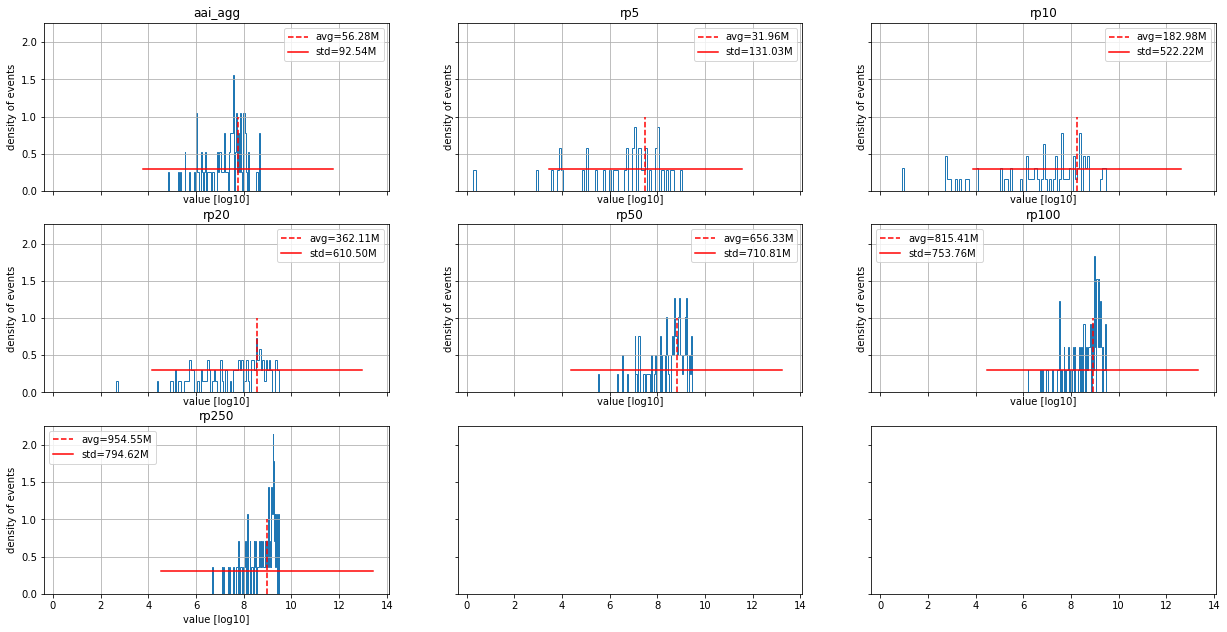

In [26]:
unc.plot_metric_distribution();

No handles with labels found to put in legend.


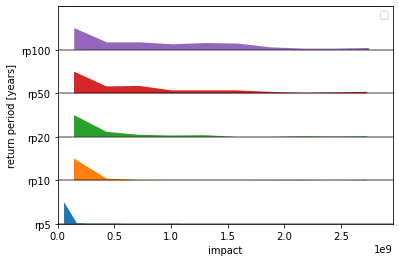

In [27]:
unc.plot_rp_distribution();

In [31]:
imp_sobol_dict = unc.calc_impact_sensitivity()

In [ ]:
unc = UncSensitivity(exp, impf_unc, haz)
imp_sobol_dict = unc.calc_impact_sobol_sensitivity(N=100, calc_eai_exp=False, calc_at_event=False, calc_second_order=True)

In [34]:
S1_aai_agg = { k:list(imp_sobol_dict['aai_agg']['aai_agg'][k]) for k in ['S1', 'S1_conf', 'ST', 'ST_conf']}

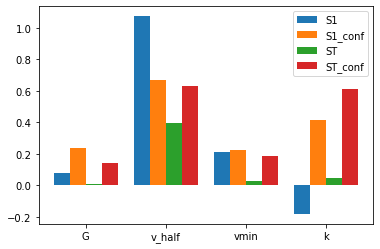

In [35]:
fig, ax = plt.subplots()
multibar_plot(ax, S1_aai_agg)
plt.setp(ax, xticks=range(len(unc.params.columns.to_list())), xticklabels=unc.params.columns.to_list());

In [56]:
all_S1 = {metric: list(metric_dict[metric]['S1']) for metric_dict in imp_sobol_dict.values() for metric in metric_dict.keys()}

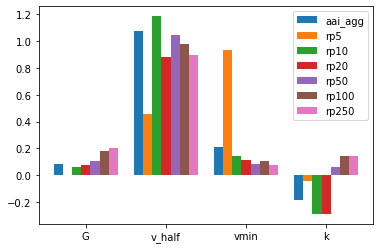

In [57]:
fig, ax = plt.subplots()
multibar_plot(ax, all_S1)
plt.setp(ax, xticks=range(len(unc.params.columns.to_list())), xticklabels=unc.params.columns.to_list());

## Cost Benefit 

In [10]:
def load_ent():
    entity = Entity()
    entity.read_mat(ENT_TEST_MAT)
    entity.check()
    entity.measures._data['TC'] = entity.measures._data.pop('XX')
    for meas in entity.measures.get_measure('TC'):
        meas.haz_type = 'TC'
    entity.check()
    return entity

def haz_unc_fct(x=1):
    hazard = Hazard('TC')
    hazard.read_mat(HAZ_TEST_MAT)
    hazard.intensity = hazard.intensity.multiply(x)
    return hazard

In [11]:
ent = load_ent()
unc_haz = UncVar(haz_unc_fct, {'x': sp.stats.norm(1, 1)})

In [14]:
pool = Pool()
unc = UncCostBenefit(unc_haz, ent, pool=pool)
unc.make_sample(N=10)
unc.calc_cost_benefit_distribution()
pool.close()
pool.join()
pool.clear()


Measure              Cost (USD k)    Benefit (USD k)    Benefit/Cost
-----------------  --------------  -----------------  --------------
Mangroves             1.31177e+06           24.1242      1.83906e-05
Beach nourishment     1.728e+06             24.1242      1.39608e-05
Seawall               8.87878e+06            0           0
Building code         9.2e+06                6.03106     6.5555e-07

--------------------  --------  -------
Total climate risk:    24.1242  (USD k)
Average annual risk:   24.1242  (USD k)
Residual risk:        -30.1553  (USD k)
--------------------  --------  -------
Net Present Values

Measure              Cost (USD k)    Benefit (USD k)    Benefit/Cost
-----------------  --------------  -----------------  --------------
Mangroves             1.31177e+06           24.1242      1.83906e-05
Beach nourishment     1.728e+06             24.1242      1.39608e-05
Seawall               8.87878e+06            0           0
Building code         9.2e+06           

Building code             9200               86.7688      0.00943139

Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177             4.01333         3.05948
Beach nourishment          1.728               3.15988         1.82863
Seawall                    8.87878            30.7145          3.45932
Building code              9.2                10.6706          1.15985



--------------------  --------  --------
Total climate risk:   42.6825   (USD bn)
Average annual risk:  42.6825   (USD bn)
Residual risk:        -5.87585  (USD bn)
--------------------  --------  --------

--------------------  --------  --------
Total climate risk:   42.6825   (USD bn)
Average annual risk:  42.6825   (USD bn)
Residual risk:        -5.87585  (USD bn)
--------------------  --------  --------Net Present Values
--------------------  --------  -------
Total climate risk:    347.075  

Building code              9.2                 6.8802         0.747848


Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Mangroves                  1.31177             3.31769        2.52918
Beach nourishment          1.728               2.59933        1.50424
Seawall                    8.87878            16.6335         1.8734
Building code              9.2                 6.8802         0.747848
--------------------  --------  --------
Total climate risk:   27.5208   (USD bn)
Average annual risk:  27.5208   (USD bn)
Residual risk:        -1.90995  (USD bn)
--------------------  --------  --------

--------------------  --------  --------
Total climate risk:   27.5208   (USD bn)
Average annual risk:  27.5208   (USD bn)
Residual risk:        -1.90995  (USD bn)
--------------------  --------  --------
Net Present ValuesNet Present Values


Measure              Cost (USD k)    Benefit (USD k)   

In [15]:
pool = Pool()
unc.pool = pool
unc.calc_cost_benefit_sensitivity()
pool.close()
pool.join()
pool.clear()

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:93: RuntimeWarning: invalid value encountered in subtract
  Y = (Y - Y.mean()) / Y.std()
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:93: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()


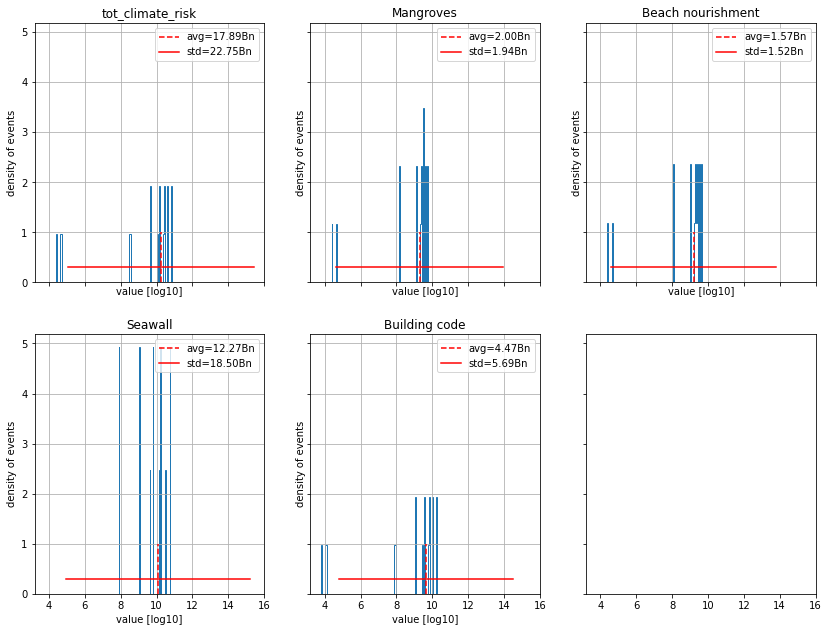

In [19]:
unc.plot_metric_distribution(list(unc.metrics.keys())[0:2]);